In [1]:
import pandas as pd

Import CSV files

In [2]:
visit = pd.read_csv('visits.csv')
test = pd.read_csv('fitness_tests.csv')
application = pd.read_csv('applications.csv')
purchase = pd.read_csv('purchases.csv')

Merge all files into one

In [3]:
df = visit.merge(test, how='left').merge(application, how='left').merge(purchase, how='left')

Fitness test was offered on July 1, 2017

In [4]:
df = df[df['visit_date']>='7-1-17'].reset_index(drop=True)

In [5]:
df['visit_date'] = pd.to_datetime(df['visit_date'])

Drop the email column

In [6]:
df = df.drop(['email'], axis=1)

In [7]:
df.head()

,first_name,last_name,gender,visit_date,fitness_test_date,application_date,purchase_date
0,Kim,Walter,female,2017-07-01,2017-07-03,NaN,NaN
1,Tom,Webster,male,2017-07-01,2017-07-02,NaN,NaN
2,Edward,Bowen,male,2017-07-01,NaN,2017-07-04,2017-07-04
3,Marcus,Bauer,male,2017-07-01,2017-07-01,2017-07-03,2017-07-05
4,Roberta,Best,female,2017-07-01,2017-07-02,NaN,NaN


In [8]:
df.shape

(5004, 7)

Make new columns on for better understanding

In [9]:
df['ab_test'] = df.fitness_test_date.apply(lambda x: 'A' if pd.notnull(x) else 'B')
df['filed_application'] = df.application_date.apply(lambda x: 'Yes' if pd.notnull(x) else 'No')
df['made_purchase'] = df.purchase_date.apply(lambda x: 'Yes' if pd.notnull(x) else 'No')

df.head()

,first_name,last_name,gender,visit_date,fitness_test_date,application_date,purchase_date,ab_test,filed_application,made_purchase
0,Kim,Walter,female,2017-07-01,2017-07-03,NaN,NaN,A,No,No
1,Tom,Webster,male,2017-07-01,2017-07-02,NaN,NaN,A,No,No
2,Edward,Bowen,male,2017-07-01,NaN,2017-07-04,2017-07-04,B,Yes,Yes
3,Marcus,Bauer,male,2017-07-01,2017-07-01,2017-07-03,2017-07-05,A,Yes,Yes
4,Roberta,Best,female,2017-07-01,2017-07-02,NaN,NaN,A,No,No


In [10]:
ab = df.groupby(['ab_test']).first_name.count().reset_index()
ab

,ab_test,first_name
0,A,2504
1,B,2500


In [11]:
from matplotlib import pyplot as plt

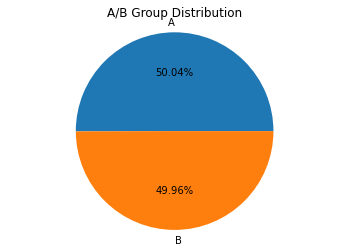

In [12]:
plt.pie(ab['first_name'], labels=ab['ab_test'], autopct="%.2f%%")
plt.axis('equal')
plt.title('A/B Group Distribution')
plt.savefig('AB Group Distribution.png')
plt.show()

In [13]:
file_app = df.groupby(['ab_test', 'filed_application']).first_name.count().reset_index()
file_app_pivot = file_app.pivot(columns='filed_application', index='ab_test', values='first_name').reset_index()
file_app_pivot['total'] = file_app_pivot.apply(lambda row: row['No']+row['Yes'], axis=1)
file_app_pivot['pct'] = file_app_pivot.apply(lambda row: 100.0*row['Yes']/row['total'], axis=1)
file_app_pivot

filed_application,ab_test,No,Yes,total,pct
0,A,2254,250,2504,9.984026
1,B,2175,325,2500,13.000000


Use chi2_contingency to test the statistical significance

In [14]:
from scipy.stats import chi2_contingency
table = [
    [250, 2254],
    [325, 2175]
]
_, pval, _, _ = chi2_contingency(table)
pval

0.0009647827600722304

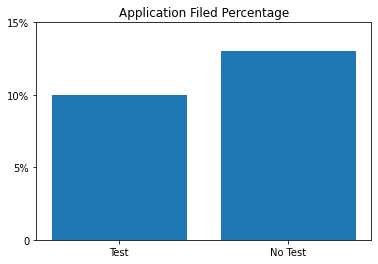

In [15]:
ax = plt.subplot()
plt.bar(range(2), file_app_pivot.pct)
ax.set_xticks(range(2))
ax.set_xticklabels(['Test', 'No Test'])
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0', '5%', '10%', '15%'])

plt.title('Application Filed Percentage')

plt.savefig('Application Filed Percentage.png')
plt.show()

In [16]:
app_to_purchase = df.groupby(['ab_test', 'filed_application', 'made_purchase']).first_name.count().reset_index()
app_to_purchase = app_to_purchase[app_to_purchase['filed_application'] == 'Yes']
app_to_purchase_pivot = app_to_purchase.pivot(columns='made_purchase', index='ab_test', values='first_name').reset_index()
app_to_purchase_pivot['total'] = app_to_purchase_pivot.apply(lambda row: row['No']+row['Yes'], axis=1)
app_to_purchase_pivot['pct'] = app_to_purchase_pivot.apply(lambda row: 100.0*row['Yes']/row['total'], axis=1)
app_to_purchase_pivot

made_purchase,ab_test,No,Yes,total,pct
0,A,50,200,250,80.000000
1,B,75,250,325,76.923077


In [17]:
table2 = [
    [200, 50],
    [250, 75]
]
_, pval, _, _ = chi2_contingency(table2)
pval

0.43258646051083327

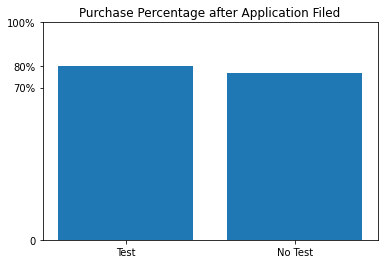

In [18]:
ax = plt.subplot()
plt.bar(range(2), app_to_purchase_pivot.pct)
ax.set_xticks(range(2))
ax.set_xticklabels(['Test', 'No Test'])
ax.set_yticks([0, 70, 80, 100])
ax.set_yticklabels(['0', '70%', '80%', '100%'])

plt.title('Purchase Percentage after Application Filed')
plt.savefig('Purchase Percentage after Application Filed.png')

plt.show()

In [19]:
ab_to_purchase = df.groupby(['ab_test', 'made_purchase']).first_name.count().reset_index()
ab_to_purchase_pivot = ab_to_purchase.pivot(columns='made_purchase', index='ab_test', values='first_name').reset_index()
ab_to_purchase_pivot['total'] = ab_to_purchase_pivot.apply(lambda row: row['No']+row['Yes'], axis=1)
ab_to_purchase_pivot['pct'] = ab_to_purchase_pivot.apply(lambda row: 100.0*row['Yes']/row['total'], axis=1)
ab_to_purchase_pivot

made_purchase,ab_test,No,Yes,total,pct
0,A,2304,200,2504,7.98722
1,B,2250,250,2500,10.00000


In [20]:
table3 = [
    [200, 2304],
    [250, 2250]
]
_, pval, _, _ = chi2_contingency(table3)
pval

0.014724114645783203

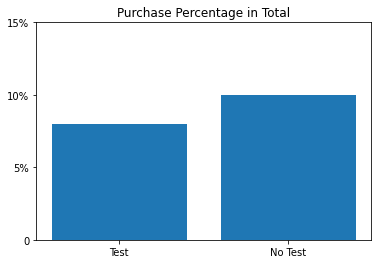

In [21]:
ax = plt.subplot()
plt.bar(range(2), ab_to_purchase_pivot.pct)
ax.set_xticks(range(2))
ax.set_xticklabels(['Test', 'No Test'])
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0', '5%', '10%', '15%'])

plt.title('Purchase Percentage in Total')
plt.savefig('Purchase Percentage in Total.png')
plt.show()

Look into gender with application filed

In [22]:
gender = df[['gender', 'ab_test', 'filed_application', 'made_purchase']]
gender.head()

,gender,ab_test,filed_application,made_purchase
0,female,A,No,No
1,male,A,No,No
2,male,B,Yes,Yes
3,male,A,Yes,Yes
4,female,A,No,No


In [23]:
gender_group = gender.groupby(['gender', 'ab_test', 'filed_application']).made_purchase.count().reset_index()

gender_group

,gender,ab_test,filed_application,made_purchase
0,female,A,No,1140
1,female,A,Yes,115
2,female,B,No,1139
3,female,B,Yes,170
4,male,A,No,1114
5,male,A,Yes,135
6,male,B,No,1036
7,male,B,Yes,155


In [24]:
female_group = gender_group.iloc[:4,]
female_group_pivot = female_group.pivot(columns='filed_application', index='ab_test', values='made_purchase').reset_index()
female_group_pivot['total'] = female_group_pivot.apply(lambda row: row['No']+row['Yes'], axis=1)
female_group_pivot['pct'] = female_group_pivot.apply(lambda row: 100.0*row['Yes']/row['total'], axis=1)
female_group_pivot

filed_application,ab_test,No,Yes,total,pct
0,A,1140,115,1255,9.163347
1,B,1139,170,1309,12.987013


In [25]:
table_female = [
    [115, 1140],
    [170, 1139]
]
_, pval, _, _ = chi2_contingency(table_female)
pval

0.00255843109789026

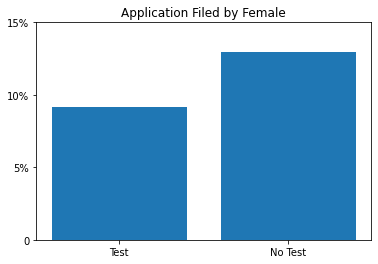

In [26]:
ax = plt.subplot()
plt.bar(range(2), female_group_pivot.pct)
ax.set_xticks(range(2))
ax.set_xticklabels(['Test', 'No Test'])
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0', '5%', '10%', '15%'])

plt.title('Application Filed by Female')
plt.savefig('Application Filed by Female.png')
plt.show()

In [27]:
table_male = [
    [135, 1114],
    [155, 1036]
]
_, pval, _, _ = chi2_contingency(table_male)
pval

0.10517283291362242

In [28]:
male_group = gender_group.iloc[4:,]
male_group_pivot = male_group.pivot(columns='filed_application', index='ab_test', values='made_purchase').reset_index()
male_group_pivot['total'] = male_group_pivot.apply(lambda row: row['No']+row['Yes'], axis=1)
male_group_pivot['pct'] = male_group_pivot.apply(lambda row: 100.0*row['Yes']/row['total'], axis=1)
male_group_pivot

filed_application,ab_test,No,Yes,total,pct
0,A,1114,135,1249,10.808647
1,B,1036,155,1191,13.014274


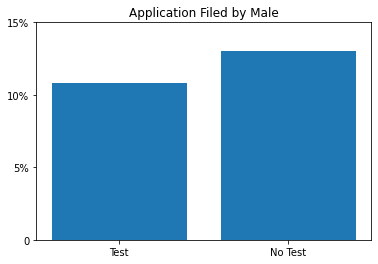

In [29]:
ax = plt.subplot()
plt.bar(range(2), male_group_pivot.pct)
ax.set_xticks(range(2))
ax.set_xticklabels(['Test', 'No Test'])
ax.set_yticks([0, 5, 10, 15])
ax.set_yticklabels(['0', '5%', '10%', '15%'])

plt.title('Application Filed by Male')
plt.savefig('Application Filed by Male.png')
plt.show()

Look into gender with end purchase

In [30]:
gender_app_pur = gender[gender['filed_application']=='Yes']
gender_app_pur_group = gender_app_pur.groupby(['gender', 'ab_test', 'made_purchase']).filed_application.count().reset_index()
gender_app_pur_group

,gender,ab_test,made_purchase,filed_application
0,female,A,No,19
1,female,A,Yes,96
2,female,B,No,37
3,female,B,Yes,133
4,male,A,No,31
5,male,A,Yes,104
6,male,B,No,38
7,male,B,Yes,117


In [31]:
female_app_pur_group = gender_app_pur_group.iloc[:4,]
female_app_pur_group_pivot = female_app_pur_group.pivot(columns='made_purchase', index='ab_test', values='filed_application').reset_index()
female_app_pur_group_pivot['total'] = female_app_pur_group_pivot.apply(lambda row: row['No']+row['Yes'], axis=1)
female_app_pur_group_pivot['pct'] = female_app_pur_group_pivot.apply(lambda row: 100.0*row['Yes']/row['total'], axis=1)
female_app_pur_group_pivot

made_purchase,ab_test,No,Yes,total,pct
0,A,19,96,115,83.478261
1,B,37,133,170,78.235294


In [32]:
table_female_p = [
    [96, 19],
    [133, 37]
]
_, pval, _, _ = chi2_contingency(table_female_p)
pval

0.3467466252308301

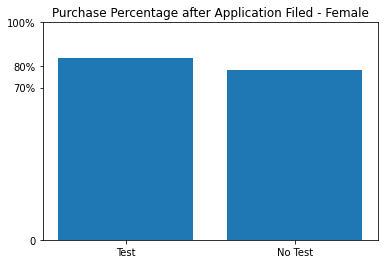

In [33]:
ax = plt.subplot()
plt.bar(range(2), female_app_pur_group_pivot.pct)
ax.set_xticks(range(2))
ax.set_xticklabels(['Test', 'No Test'])
ax.set_yticks([0, 70, 80, 100])
ax.set_yticklabels(['0', '70%', '80%', '100%'])

plt.title('Purchase Percentage after Application Filed - Female')
plt.savefig('Purchase Percentage after Application Filed - Female.png')
plt.show()

In [34]:
male_app_pur_group = gender_app_pur_group.iloc[4:,]
male_app_pur_group_pivot = male_app_pur_group.pivot(columns='made_purchase', index='ab_test', values='filed_application').reset_index()
male_app_pur_group_pivot['total'] = male_app_pur_group_pivot.apply(lambda row: row['No']+row['Yes'], axis=1)
male_app_pur_group_pivot['pct'] = male_app_pur_group_pivot.apply(lambda row: 100.0*row['Yes']/row['total'], axis=1)
male_app_pur_group_pivot

made_purchase,ab_test,No,Yes,total,pct
0,A,31,104,135,77.037037
1,B,38,117,155,75.483871


In [35]:
table_male_p = [
    [31, 104],
    [38, 117]
]
_, pval, _, _ = chi2_contingency(table_male_p)
pval

0.8637517573766746

In [36]:
table_female_male = [
    [31, 104],
    [19, 96]
]
_, pval, _, _ = chi2_contingency(table_female_male)
pval

0.26684564040824404

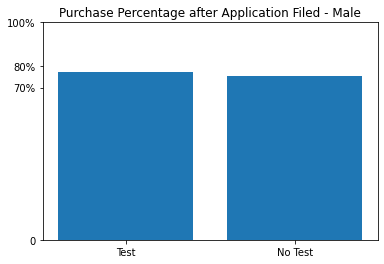

In [37]:
ax = plt.subplot()
plt.bar(range(2), male_app_pur_group_pivot.pct)
ax.set_xticks(range(2))
ax.set_xticklabels(['Test', 'No Test'])
ax.set_yticks([0, 70, 80, 100])
ax.set_yticklabels(['0', '70%', '80%', '100%'])

plt.title('Purchase Percentage after Application Filed - Male')
plt.savefig('Purchase Percentage after Application Filed - Male.png')
plt.show()

# Look into by days

In [38]:
df_date = df[['gender', 'visit_date', 'fitness_test_date', 'application_date', 'purchase_date', 'ab_test', 'filed_application', 'made_purchase']]
df_date.head()

,gender,visit_date,fitness_test_date,application_date,purchase_date,ab_test,filed_application,made_purchase
0,female,2017-07-01,2017-07-03,NaN,NaN,A,No,No
1,male,2017-07-01,2017-07-02,NaN,NaN,A,No,No
2,male,2017-07-01,NaN,2017-07-04,2017-07-04,B,Yes,Yes
3,male,2017-07-01,2017-07-01,2017-07-03,2017-07-05,A,Yes,Yes
4,female,2017-07-01,2017-07-02,NaN,NaN,A,No,No


In [39]:
df_date['application_date'] = pd.to_datetime(df_date['application_date'])
df_date['purchase_date'] = pd.to_datetime(df_date['purchase_date'])
df_date['visit_app'] = df_date.apply(lambda row: row['application_date']-row['visit_date'], axis=1)
df_date['app_purchase'] = df_date.apply(lambda row: row['purchase_date']-row['application_date'], axis=1)
df_date.head()

<ipython-input-39-c66be492dabf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date['application_date'] = pd.to_datetime(df_date['application_date'])
<ipython-input-39-c66be492dabf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_date['purchase_date'] = pd.to_datetime(df_date['purchase_date'])
<ipython-input-39-c66be492dabf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,gender,visit_date,fitness_test_date,application_date,purchase_date,ab_test,filed_application,made_purchase,visit_app,app_purchase
0,female,2017-07-01,2017-07-03,NaT,NaT,A,No,No,NaT,NaT
1,male,2017-07-01,2017-07-02,NaT,NaT,A,No,No,NaT,NaT
2,male,2017-07-01,NaN,2017-07-04,2017-07-04,B,Yes,Yes,3 days,0 days
3,male,2017-07-01,2017-07-01,2017-07-03,2017-07-05,A,Yes,Yes,2 days,2 days
4,female,2017-07-01,2017-07-02,NaT,NaT,A,No,No,NaT,NaT


In [40]:
df_date_purchase = df_date.dropna(subset=['visit_app'], axis=0)
df_date_purchase.head()

,gender,visit_date,fitness_test_date,application_date,purchase_date,ab_test,filed_application,made_purchase,visit_app,app_purchase
2,male,2017-07-01,NaN,2017-07-04,2017-07-04,B,Yes,Yes,3 days,0 days
3,male,2017-07-01,2017-07-01,2017-07-03,2017-07-05,A,Yes,Yes,2 days,2 days
9,male,2017-07-01,2017-07-07,2017-07-06,NaT,A,Yes,No,5 days,NaT
11,female,2017-07-01,2017-07-03,2017-07-05,2017-07-06,A,Yes,Yes,4 days,1 days
35,male,2017-07-01,NaN,2017-07-07,2017-07-13,B,Yes,Yes,6 days,6 days


In [41]:
time_span_file = df_date_purchase[['ab_test', 'filed_application', 'made_purchase', 'visit_app', 'app_purchase']].reset_index(drop=True)
time_span_file = time_span_file[time_span_file['filed_application']=='Yes']
time_span_file.head()

,ab_test,filed_application,made_purchase,visit_app,app_purchase
0,B,Yes,Yes,3 days,0 days
1,A,Yes,Yes,2 days,2 days
2,A,Yes,No,5 days,NaT
3,A,Yes,Yes,4 days,1 days
4,B,Yes,Yes,6 days,6 days


In [42]:
time_span_file.shape

(575, 5)

In [43]:
time_span_file_group = time_span_file.groupby(['ab_test', 'visit_app']).filed_application.count().reset_index()
time_span_file_group

,ab_test,visit_app,filed_application
0,A,0 days,30
1,A,1 days,23
2,A,2 days,31
3,A,3 days,41
4,A,4 days,48
5,A,5 days,35
6,A,6 days,42
7,B,0 days,44
8,B,1 days,50
9,B,2 days,50


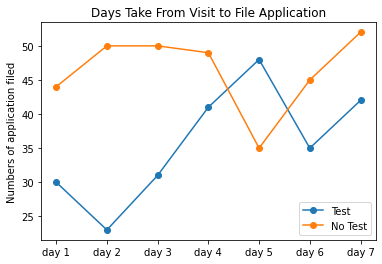

In [44]:
ax = plt.subplot()
plt.plot(range(7), time_span_file_group.iloc[:7, 2], marker='o', label='Test')
plt.plot(range(7), time_span_file_group.iloc[7:, 2], marker='o', label='No Test')
plt.legend()

ax.set_xticks(range(7))
ax.set_xticklabels(['day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7'])

plt.title('Days Take From Visit to File Application')
plt.ylabel('Numbers of application filed')

plt.savefig('Days Take From Visit to File Application.png')
plt.show()

In [45]:
app_to_purchase = time_span_file.groupby(['ab_test', 'app_purchase']).filed_application.count().reset_index()
app_to_purchase.head()

,ab_test,app_purchase,filed_application
0,A,0 days,22
1,A,1 days,36
2,A,2 days,33
3,A,3 days,28
4,A,4 days,26


In [46]:
app_to_purchase_group = time_span_file.groupby(['ab_test', 'app_purchase']).made_purchase.count().reset_index()
app_to_purchase_group

,ab_test,app_purchase,made_purchase
0,A,0 days,22
1,A,1 days,36
2,A,2 days,33
3,A,3 days,28
4,A,4 days,26
5,A,5 days,25
6,A,6 days,30
7,B,0 days,45
8,B,1 days,27
9,B,2 days,35


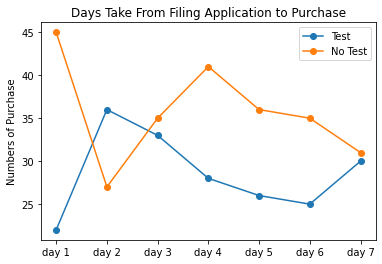

In [47]:
ax = plt.subplot()
plt.plot(range(7), app_to_purchase_group.iloc[:7, 2], marker='o', label='Test')
plt.plot(range(7), app_to_purchase_group.iloc[7:, 2], marker='o', label='No Test')
plt.legend()

ax.set_xticks(range(7))
ax.set_xticklabels(['day 1', 'day 2', 'day 3', 'day 4', 'day 5', 'day 6', 'day 7'])

plt.title('Days Take From Filing Application to Purchase')
plt.ylabel('Numbers of Purchase')

plt.savefig('Days Take From Filing Application to Purchase.png')
plt.show()

# Machine learning tests

In [48]:
df_date.head()

,gender,visit_date,fitness_test_date,application_date,purchase_date,ab_test,filed_application,made_purchase,visit_app,app_purchase
0,female,2017-07-01,2017-07-03,NaT,NaT,A,No,No,NaT,NaT
1,male,2017-07-01,2017-07-02,NaT,NaT,A,No,No,NaT,NaT
2,male,2017-07-01,NaN,2017-07-04,2017-07-04,B,Yes,Yes,3 days,0 days
3,male,2017-07-01,2017-07-01,2017-07-03,2017-07-05,A,Yes,Yes,2 days,2 days
4,female,2017-07-01,2017-07-02,NaT,NaT,A,No,No,NaT,NaT


In [49]:
asdf = df_date[['visit_app']]
asdf['visit_app'] = asdf['visit_app'].astype('str')
asdf.dtypes

<ipython-input-49-ccf62a24e91c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  asdf['visit_app'] = asdf['visit_app'].astype('str')


visit_app    object
dtype: object

In [50]:
features = df_date[['gender', 'ab_test', 'visit_app']]


In [51]:
features['gender'] = features.gender.map({'female': 1, 'male': 0})
features['ab_test'] = features.ab_test.map({'A': 1, 'B': 0})
features['visit_app'] = features.visit_app.apply(lambda x: 1 if pd.notnull(x) else 0)
#features['visit_app'] = features['visit_app'].astype('str')
#features['visit_app'] = features['visit_app'].apply(lambda x: x.split()[0])
#features['visit_app'] = features['visit_app'].astype('int')

features.head()

<ipython-input-51-b8c0e21eecda>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['gender'] = features.gender.map({'female': 1, 'male': 0})
<ipython-input-51-b8c0e21eecda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['ab_test'] = features.ab_test.map({'A': 1, 'B': 0})
<ipython-input-51-b8c0e21eecda>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,gender,ab_test,visit_app
0,1,1,0
1,0,1,0
2,0,0,1
3,0,1,1
4,1,1,0


In [52]:
labels = df_date[['app_purchase']]
labels['app_purchase'] = labels['app_purchase'].apply(lambda x: 1 if pd.notnull(x) else 0)
labels.head()

<ipython-input-52-224632fd2724>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['app_purchase'] = labels['app_purchase'].apply(lambda x: 1 if pd.notnull(x) else 0)


,app_purchase
0,0
1,0
2,1
3,1
4,0


In [53]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, labels, train_size=0.8, random_state=1)

In [54]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

C:\Users\kimki\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9690309690309691

In [55]:
print('Female with Test Enrollment Probability: {}'.format(lr.predict_proba([[1, 1, 1]])[0][1]*100))
print('Female without Test Enrollment Probability: {}'.format(lr.predict_proba([[1, 0, 1]])[0][1]*100))
print('Male with Test Enrollment Probability: {}'.format(lr.predict_proba([[0, 1, 1]])[0][1]*100))
print('Male without Test Enrollment Probability: {}'.format(lr.predict_proba([[0, 0, 1]])[0][1]*100))

Female with Test Enrollment Probability: 81.11519909692954
Female without Test Enrollment Probability: 79.4314691041082
Male with Test Enrollment Probability: 76.5680633636661
Male without Test Enrollment Probability: 74.60583996034462


In [56]:
ft = lr.predict_proba([[1, 1, 1]])[0][1]*100
fnt = lr.predict_proba([[1, 0, 1]])[0][1]*100
mt = lr.predict_proba([[0, 1, 1]])[0][1]*100
mnt = lr.predict_proba([[0, 0, 1]])[0][1]*100

In [57]:
proba = pd.DataFrame({'Test': [ft, mt], "No Test": [fnt, mnt]}, index=['Female', 'Male'])
proba.columns.name = 'Probability'
proba

Probability,Test,No Test
Female,81.115199,79.431469
Male,76.568063,74.605840


In [58]:
lr.coef_

array([[0.27343278, 0.1063806 , 7.4468604 ]])

In [59]:
coef = pd.DataFrame({'Coefficient': lr.coef_[0]}, index=['Gender', 'Test', 'Application'])
coef

,Coefficient
Gender,0.273433
Test,0.106381
Application,7.446860
